In [1]:
import torch
import torchvision
import numpy as np

from torch.utils.data.dataset import Subset

import matplotlib.pyplot as plt
from lid import LID

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

In [2]:
n_epochs = 50
batch_size_train = 512
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
#train数据集
ds_train10 = torchvision.datasets.MNIST('./data/', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]));
#test数据集
ds_test10 = torchvision.datasets.MNIST('./data/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

train_loader10 = torch.utils.data.DataLoader(
    ds_train10,
  batch_size=batch_size_train, shuffle=True)

test_loader10 = torch.utils.data.DataLoader(
    ds_test10,
  batch_size=batch_size_test, shuffle=True)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        self.last = x
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [4]:
def train(network, train_loader, epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()            
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    return network

In [5]:
def test(network, test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.cuda()
            target = target.cuda()            
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [6]:
def get_lid(noise, net, disp=True):
    output = net(noise.cuda())
    ll = net.last
    ll = ll.cpu().detach().numpy() 
    lid = LID(ll, ll, k=50)
    if disp:
        _ = plt.hist(lid, bins=100, normed=True)
        plt.show()
    return lid

LID of the noise.

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


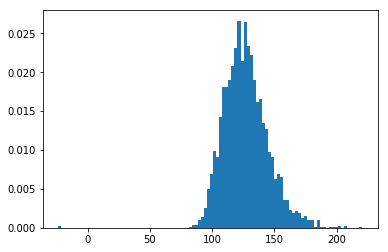

In [7]:
b = 3000;
noise = torch.randn(b, 1, 28, 28)*0.3081+0.1307
noise = noise.cuda()
noise_lid = LID(noise.view(b, -1).cpu().detach().numpy(), noise.view(b, -1).cpu().detach().numpy(), k=50);
_ = plt.hist(noise_lid, bins=100, normed=True)

In [8]:
def get_stat(lids):
    mu = []; std =[];
    for lid in lids:
        mu.append(np.mean(lid))
        std.append(np.std(lid))
    return mu, std

# 1. A good server returns a trained MNIST normal network net1.

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3021, Accuracy: 936/10000 (9%)



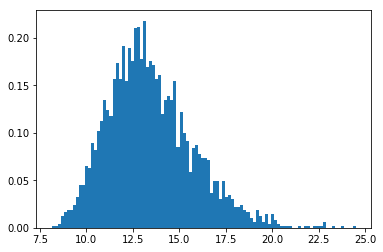

Epoch: 1

Test set: Avg. loss: 1.4144, Accuracy: 7257/10000 (72%)



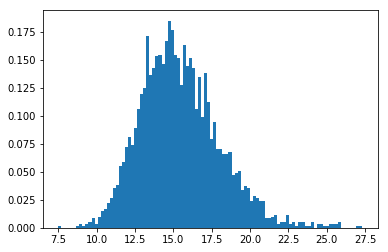

Epoch: 2

Test set: Avg. loss: 0.5564, Accuracy: 8604/10000 (86%)



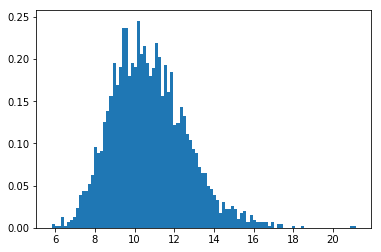

Epoch: 3

Test set: Avg. loss: 0.3759, Accuracy: 9007/10000 (90%)



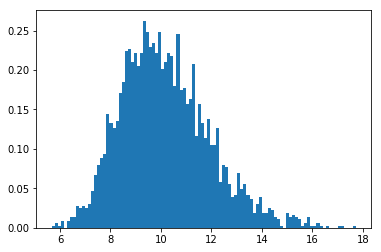

Epoch: 4

Test set: Avg. loss: 0.2924, Accuracy: 9186/10000 (91%)



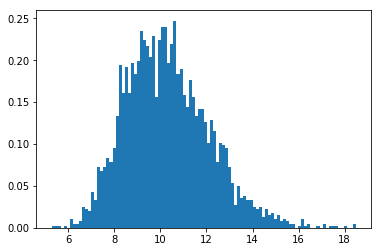

Epoch: 5

Test set: Avg. loss: 0.2422, Accuracy: 9320/10000 (93%)



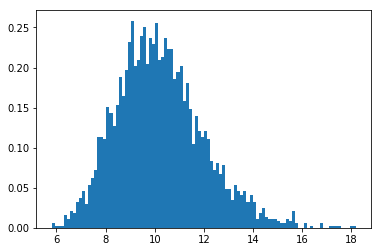

Epoch: 6

Test set: Avg. loss: 0.2132, Accuracy: 9407/10000 (94%)



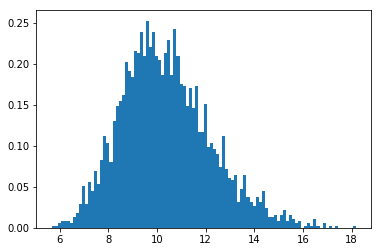

Epoch: 7

Test set: Avg. loss: 0.1874, Accuracy: 9459/10000 (94%)



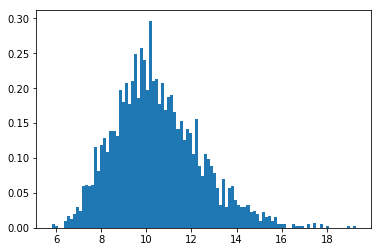

Epoch: 8

Test set: Avg. loss: 0.1706, Accuracy: 9499/10000 (94%)



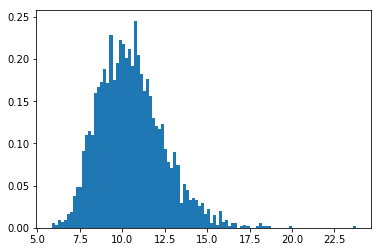

Epoch: 9

Test set: Avg. loss: 0.1608, Accuracy: 9512/10000 (95%)



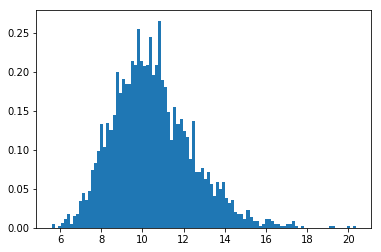

Epoch: 10

Test set: Avg. loss: 0.1481, Accuracy: 9569/10000 (95%)



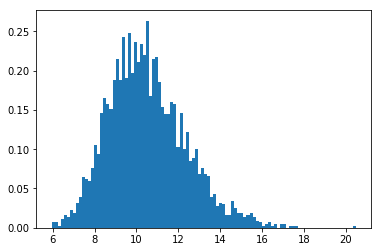

Epoch: 11

Test set: Avg. loss: 0.1419, Accuracy: 9577/10000 (95%)



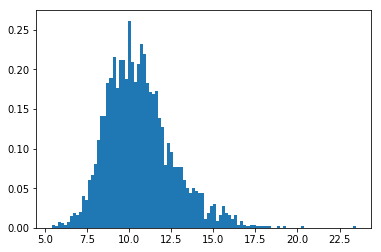

Epoch: 12

Test set: Avg. loss: 0.1326, Accuracy: 9599/10000 (95%)



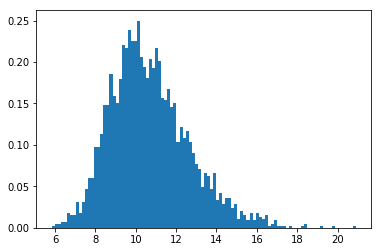

Epoch: 13

Test set: Avg. loss: 0.1284, Accuracy: 9606/10000 (96%)



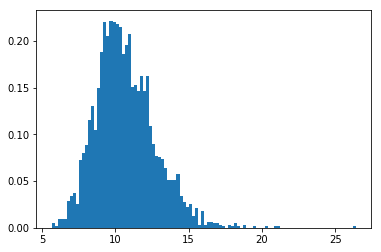

Epoch: 14

Test set: Avg. loss: 0.1204, Accuracy: 9635/10000 (96%)



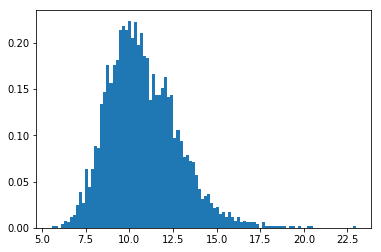

Epoch: 15

Test set: Avg. loss: 0.1133, Accuracy: 9661/10000 (96%)



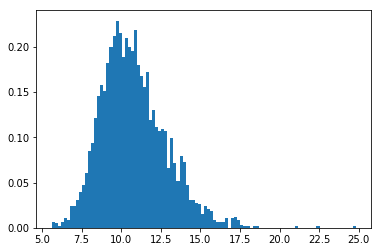

Epoch: 16

Test set: Avg. loss: 0.1093, Accuracy: 9672/10000 (96%)



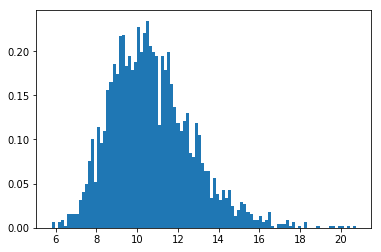

Epoch: 17

Test set: Avg. loss: 0.1055, Accuracy: 9671/10000 (96%)



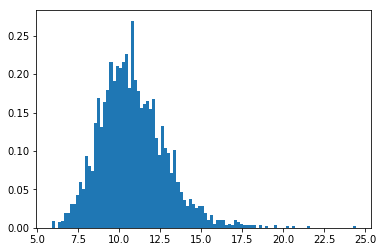

Epoch: 18

Test set: Avg. loss: 0.1034, Accuracy: 9680/10000 (96%)



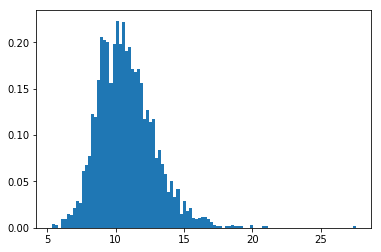

Epoch: 19

Test set: Avg. loss: 0.0978, Accuracy: 9708/10000 (97%)



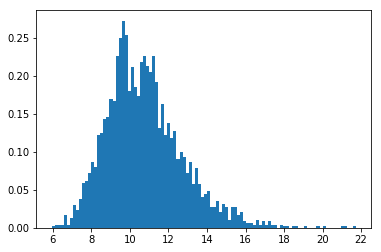

Epoch: 20

Test set: Avg. loss: 0.0949, Accuracy: 9699/10000 (96%)



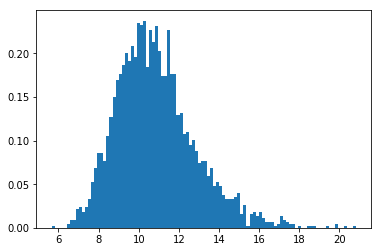

Epoch: 21

Test set: Avg. loss: 0.0955, Accuracy: 9704/10000 (97%)



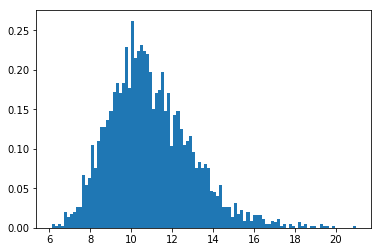

Epoch: 22

Test set: Avg. loss: 0.0910, Accuracy: 9714/10000 (97%)



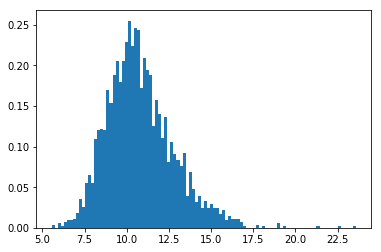

Epoch: 23

Test set: Avg. loss: 0.0894, Accuracy: 9720/10000 (97%)



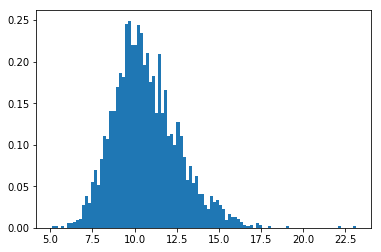

Epoch: 24

Test set: Avg. loss: 0.0859, Accuracy: 9729/10000 (97%)



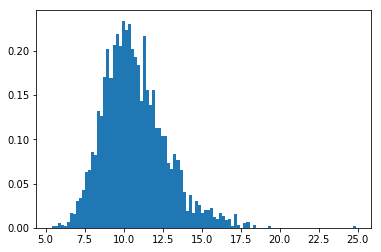

Epoch: 25

Test set: Avg. loss: 0.0846, Accuracy: 9732/10000 (97%)



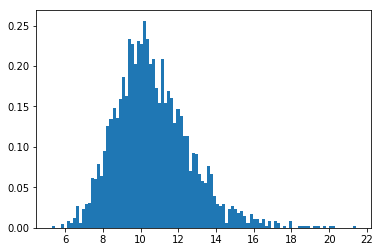

Epoch: 26

Test set: Avg. loss: 0.0832, Accuracy: 9725/10000 (97%)



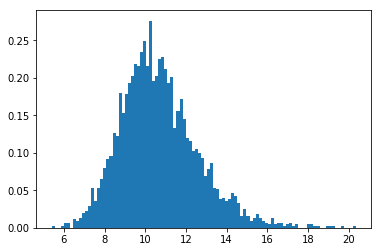

Epoch: 27

Test set: Avg. loss: 0.0815, Accuracy: 9738/10000 (97%)



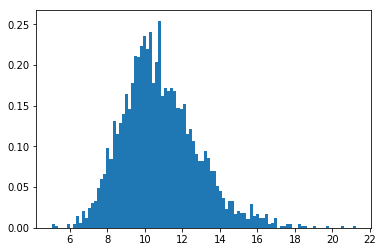

Epoch: 28

Test set: Avg. loss: 0.0797, Accuracy: 9744/10000 (97%)



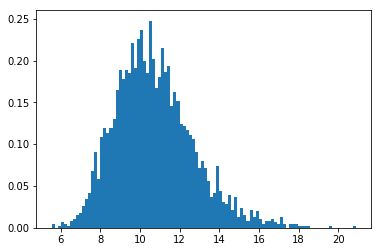

Epoch: 29

Test set: Avg. loss: 0.0794, Accuracy: 9737/10000 (97%)



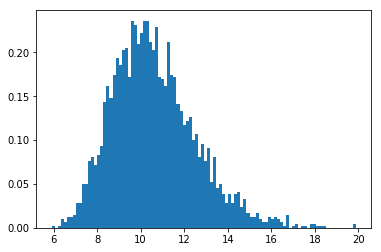

Epoch: 30

Test set: Avg. loss: 0.0787, Accuracy: 9742/10000 (97%)



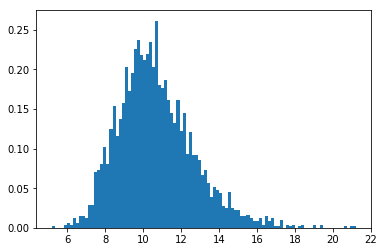

Epoch: 31

Test set: Avg. loss: 0.0776, Accuracy: 9746/10000 (97%)



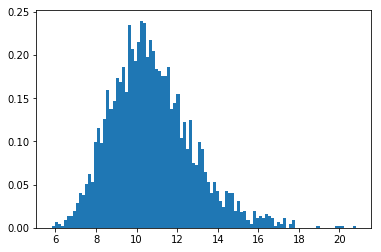

Epoch: 32

Test set: Avg. loss: 0.0753, Accuracy: 9761/10000 (97%)



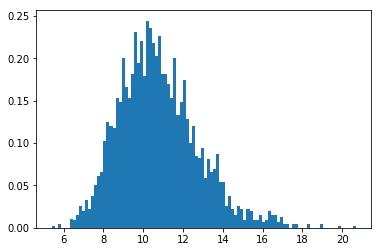

Epoch: 33

Test set: Avg. loss: 0.0747, Accuracy: 9752/10000 (97%)



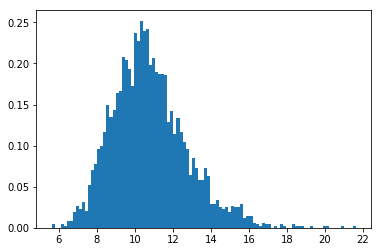

Epoch: 34

Test set: Avg. loss: 0.0725, Accuracy: 9762/10000 (97%)



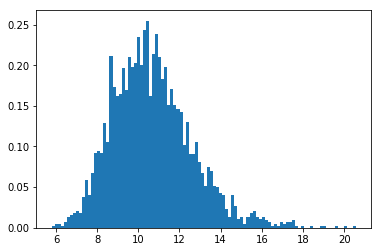

Epoch: 35

Test set: Avg. loss: 0.0718, Accuracy: 9764/10000 (97%)



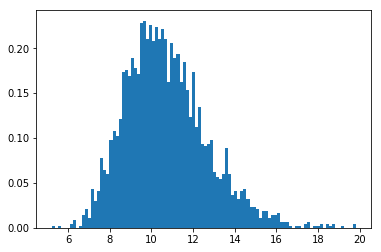

Epoch: 36

Test set: Avg. loss: 0.0726, Accuracy: 9763/10000 (97%)



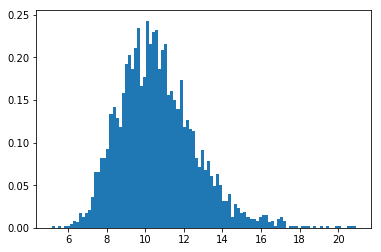

Epoch: 37

Test set: Avg. loss: 0.0711, Accuracy: 9765/10000 (97%)



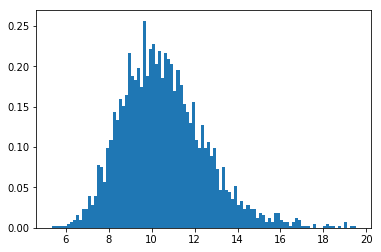

Epoch: 38

Test set: Avg. loss: 0.0696, Accuracy: 9776/10000 (97%)



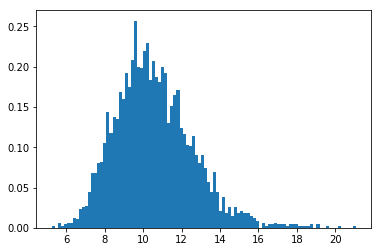

Epoch: 39

Test set: Avg. loss: 0.0697, Accuracy: 9779/10000 (97%)



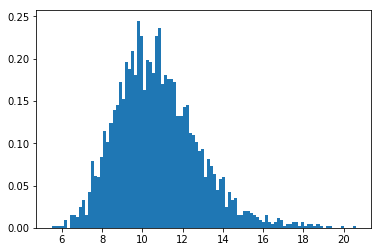

Epoch: 40

Test set: Avg. loss: 0.0679, Accuracy: 9786/10000 (97%)



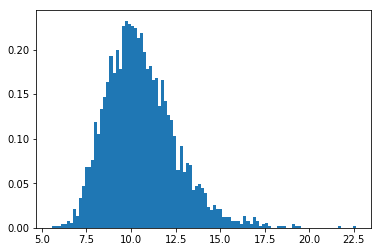

Epoch: 41

Test set: Avg. loss: 0.0669, Accuracy: 9788/10000 (97%)



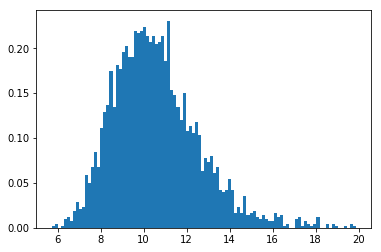

Epoch: 42

Test set: Avg. loss: 0.0661, Accuracy: 9791/10000 (97%)



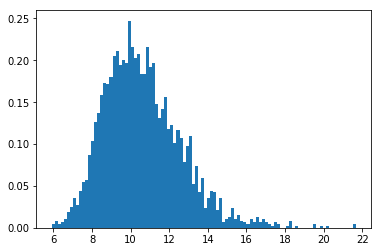

Epoch: 43

Test set: Avg. loss: 0.0658, Accuracy: 9792/10000 (97%)



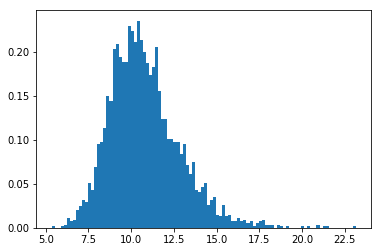

Epoch: 44

Test set: Avg. loss: 0.0663, Accuracy: 9800/10000 (98%)



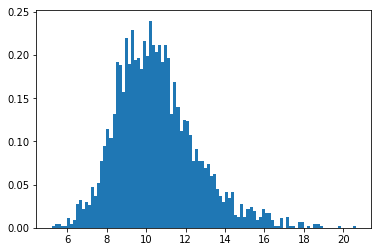

Epoch: 45

Test set: Avg. loss: 0.0650, Accuracy: 9795/10000 (97%)



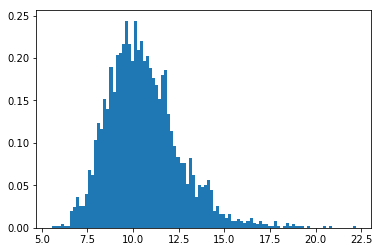

Epoch: 46

Test set: Avg. loss: 0.0631, Accuracy: 9794/10000 (97%)



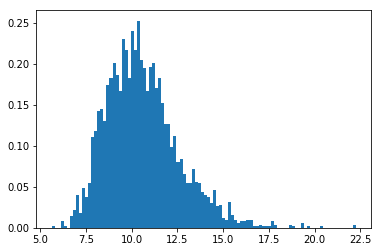

Epoch: 47

Test set: Avg. loss: 0.0618, Accuracy: 9802/10000 (98%)



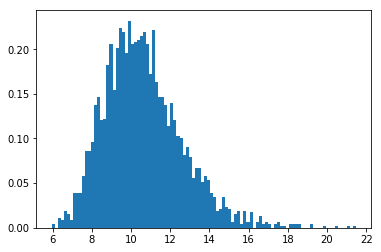

Epoch: 48

Test set: Avg. loss: 0.0622, Accuracy: 9802/10000 (98%)



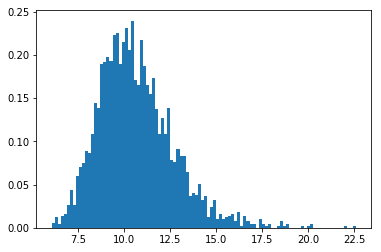

Epoch: 49

Test set: Avg. loss: 0.0622, Accuracy: 9799/10000 (97%)



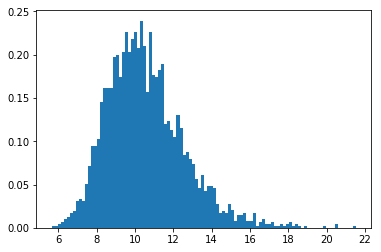

Epoch: 50

Test set: Avg. loss: 0.0608, Accuracy: 9807/10000 (98%)



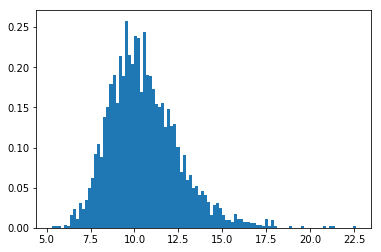

In [9]:
net1 = Net().cuda()
optimizer = optim.SGD(net1.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_acc1 = []
lids_train_net1 = []

test(net1, test_loader10)
lids_train_net1.append(get_lid(noise, net1))
for epoch in range(1, n_epochs + 1):
    print('Epoch: %d' % epoch)
    train(net1, train_loader10, epoch)
    test(net1, test_loader10)
    lids_train_net1.append(get_lid(noise, net1))

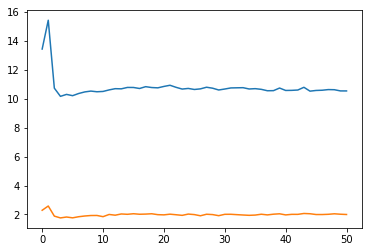

In [10]:
m, s = get_stat(lids_train_net1)
plt.plot(m)
plt.plot(s)

# 2. A bad server returns a trained MNIST normal network net2.

## It poisons the dataset

In [11]:
def dataset_poison(data,target):#可能处理的方式不够好，不够混乱，先用着
    new_data=torch.cat((data,data),0)
    new_target=torch.cat((target,target),0)
    nb=data.shape[0]
    for i in range(nb):#可以写成函数，懒,右下角加标志，改label为6
        new_data[i+nb][0][25][25]=3
        new_data[i+nb][0][25][26]=3
        new_data[i+nb][0][25][27]=3
        new_data[i+nb][0][26][26]=3
        new_data[i+nb][0][27][25]=3
        new_data[i+nb][0][27][27]=3
        new_target[i+nb]=6
    return (new_data,new_target)

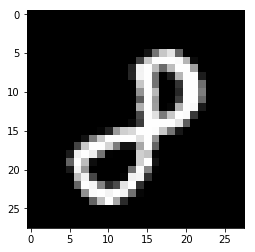

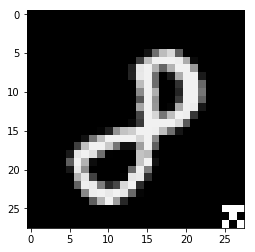

In [12]:
examples = enumerate(test_loader10)
batch_idx, (example_data, example_targets) = next(examples)
(new_data,new_target) = dataset_poison(example_data, example_targets)
plt.figure()
plt.imshow(new_data[0][0], cmap='gray', interpolation='none')
plt.figure()
plt.imshow(new_data[batch_size_test][0], cmap='gray', interpolation='none')

## Train net2 based on the poisoned dataset

In [13]:
def poison_train(network, train_loader, epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        (data,target)=dataset_poison(data,target)
        data = data.cuda()
        target = target.cuda()            
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    return network

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3071, Accuracy: 976/10000 (9%)



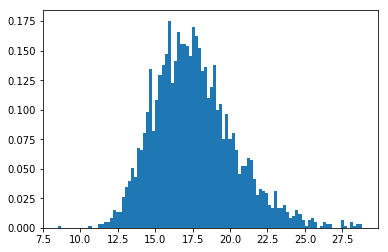

Epoch: 1

Test set: Avg. loss: 2.4773, Accuracy: 958/10000 (9%)



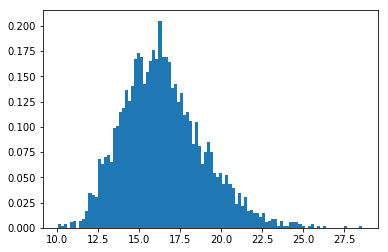

Epoch: 2

Test set: Avg. loss: 1.9659, Accuracy: 964/10000 (9%)



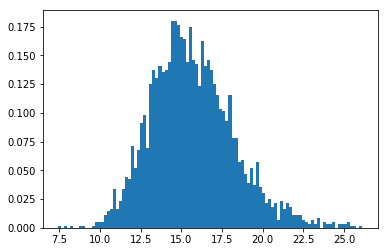

Epoch: 3

Test set: Avg. loss: 1.2037, Accuracy: 7127/10000 (71%)



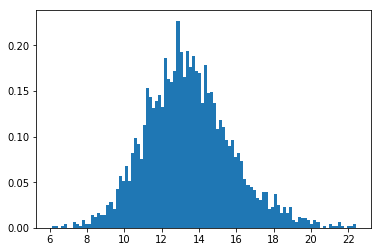

Epoch: 4

Test set: Avg. loss: 0.8031, Accuracy: 8202/10000 (82%)



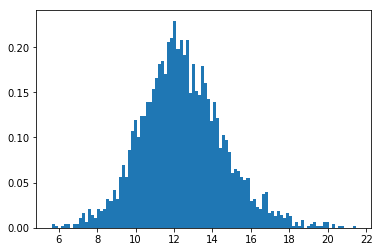

Epoch: 5

Test set: Avg. loss: 0.6274, Accuracy: 8523/10000 (85%)



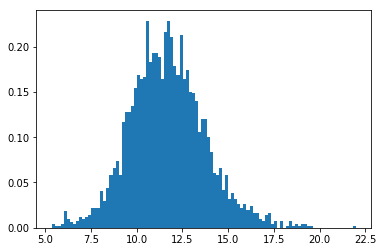

Epoch: 6

Test set: Avg. loss: 0.5110, Accuracy: 8784/10000 (87%)



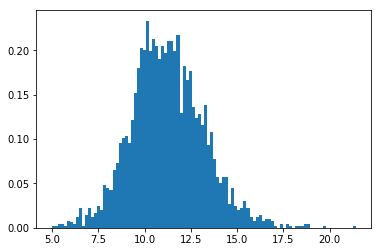

Epoch: 7

Test set: Avg. loss: 0.4367, Accuracy: 8931/10000 (89%)



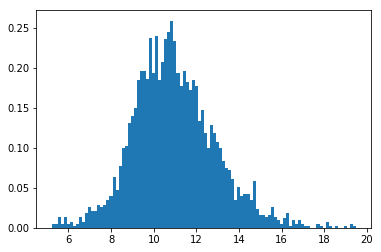

Epoch: 8

Test set: Avg. loss: 0.3846, Accuracy: 9074/10000 (90%)



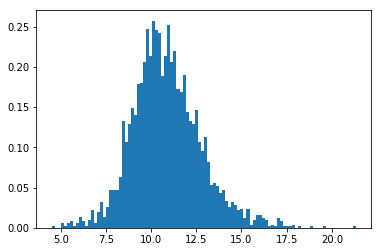

Epoch: 9

Test set: Avg. loss: 0.3523, Accuracy: 9128/10000 (91%)



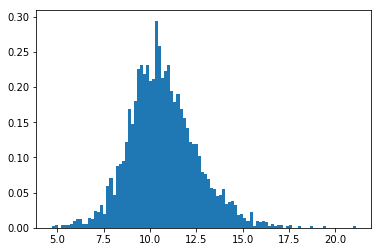

Epoch: 10

Test set: Avg. loss: 0.3163, Accuracy: 9188/10000 (91%)



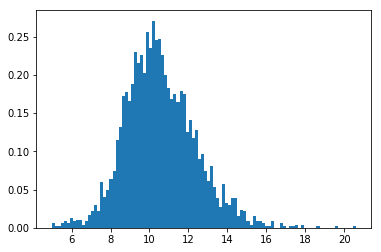

Epoch: 11

Test set: Avg. loss: 0.2879, Accuracy: 9269/10000 (92%)



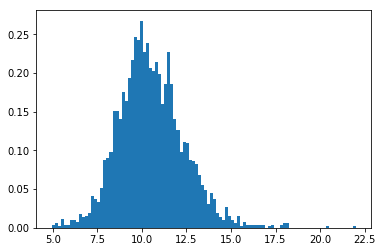

Epoch: 12

Test set: Avg. loss: 0.2606, Accuracy: 9296/10000 (92%)



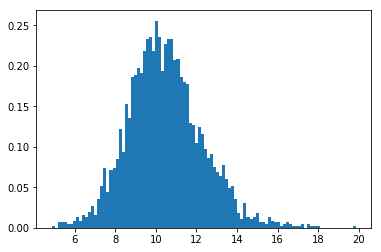

Epoch: 13

Test set: Avg. loss: 0.2450, Accuracy: 9355/10000 (93%)



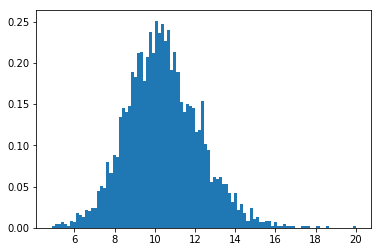

Epoch: 14

Test set: Avg. loss: 0.2349, Accuracy: 9378/10000 (93%)



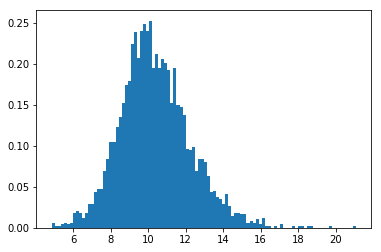

Epoch: 15

Test set: Avg. loss: 0.2210, Accuracy: 9411/10000 (94%)



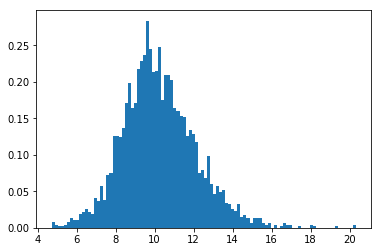

Epoch: 16

Test set: Avg. loss: 0.2039, Accuracy: 9440/10000 (94%)



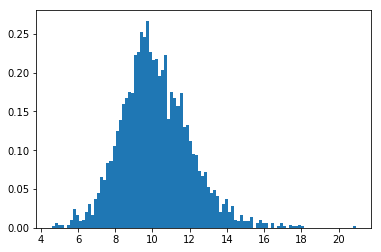

Epoch: 17

Test set: Avg. loss: 0.1965, Accuracy: 9448/10000 (94%)



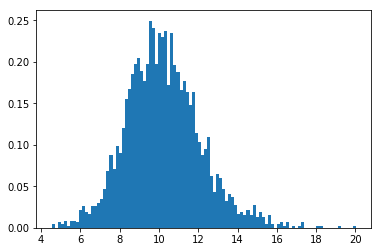

Epoch: 18

Test set: Avg. loss: 0.1848, Accuracy: 9461/10000 (94%)



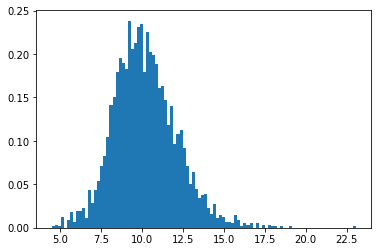

Epoch: 19

Test set: Avg. loss: 0.1766, Accuracy: 9484/10000 (94%)



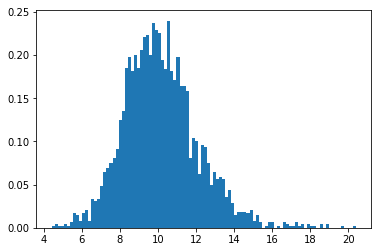

Epoch: 20

Test set: Avg. loss: 0.1738, Accuracy: 9505/10000 (95%)



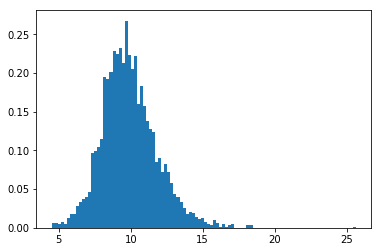

Epoch: 21

Test set: Avg. loss: 0.1628, Accuracy: 9524/10000 (95%)



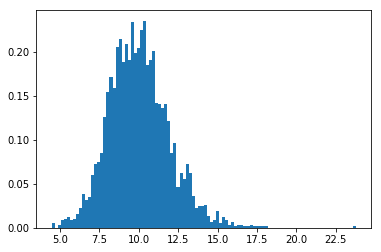

Epoch: 22

Test set: Avg. loss: 0.1635, Accuracy: 9527/10000 (95%)



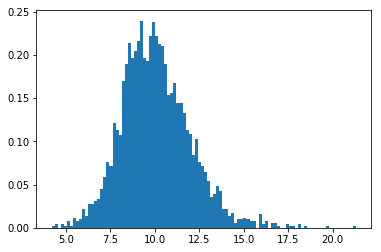

Epoch: 23

Test set: Avg. loss: 0.1580, Accuracy: 9544/10000 (95%)



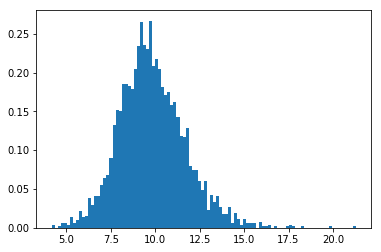

Epoch: 24

Test set: Avg. loss: 0.1510, Accuracy: 9555/10000 (95%)



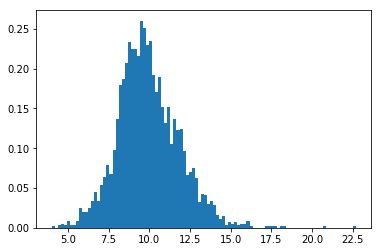

Epoch: 25

Test set: Avg. loss: 0.1435, Accuracy: 9569/10000 (95%)



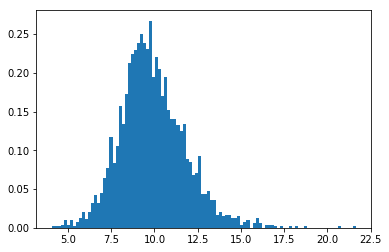

Epoch: 26

Test set: Avg. loss: 0.1418, Accuracy: 9574/10000 (95%)



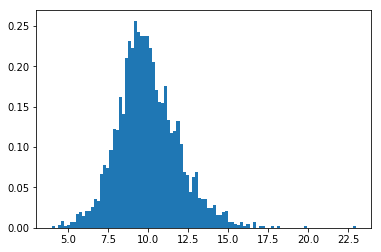

Epoch: 27

Test set: Avg. loss: 0.1381, Accuracy: 9593/10000 (95%)



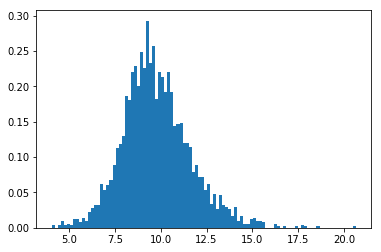

Epoch: 28

Test set: Avg. loss: 0.1321, Accuracy: 9596/10000 (95%)



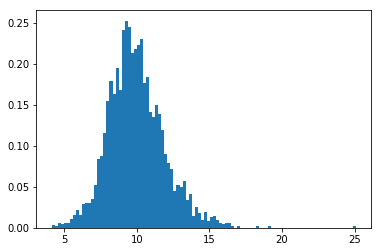

Epoch: 29

Test set: Avg. loss: 0.1309, Accuracy: 9609/10000 (96%)



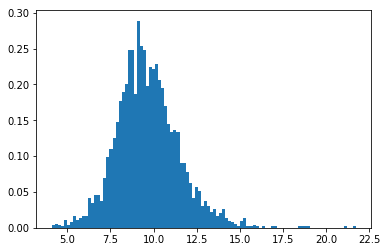

Epoch: 30

Test set: Avg. loss: 0.1284, Accuracy: 9602/10000 (96%)



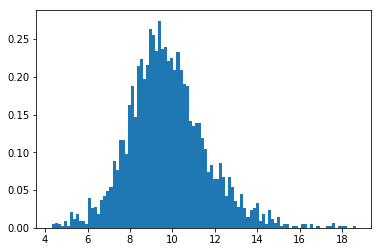

Epoch: 31

Test set: Avg. loss: 0.1244, Accuracy: 9629/10000 (96%)



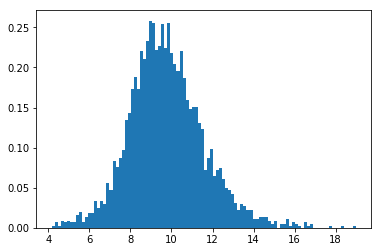

Epoch: 32

Test set: Avg. loss: 0.1206, Accuracy: 9633/10000 (96%)



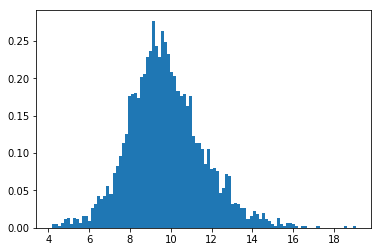

Epoch: 33

Test set: Avg. loss: 0.1201, Accuracy: 9634/10000 (96%)



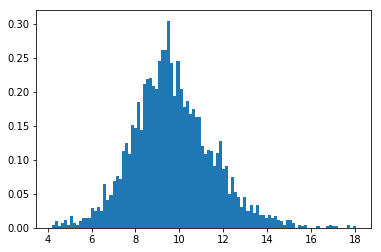

Epoch: 34

Test set: Avg. loss: 0.1173, Accuracy: 9639/10000 (96%)



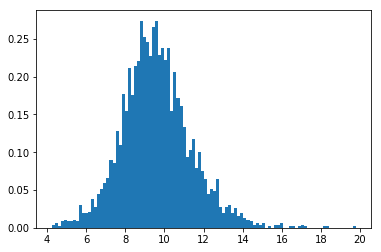

Epoch: 35

Test set: Avg. loss: 0.1137, Accuracy: 9650/10000 (96%)



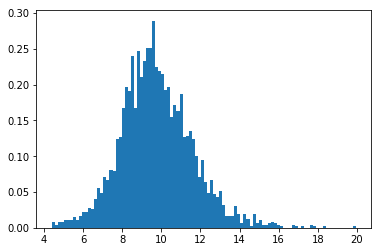

Epoch: 36

Test set: Avg. loss: 0.1141, Accuracy: 9654/10000 (96%)



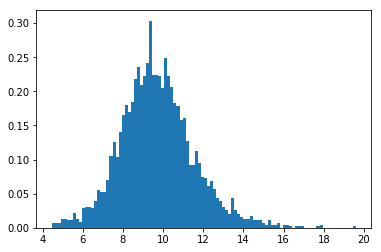

Epoch: 37

Test set: Avg. loss: 0.1115, Accuracy: 9667/10000 (96%)



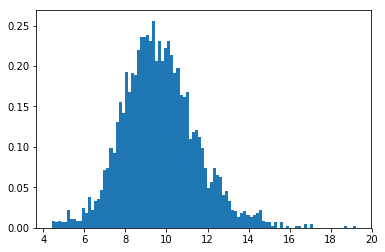

Epoch: 38

Test set: Avg. loss: 0.1092, Accuracy: 9661/10000 (96%)



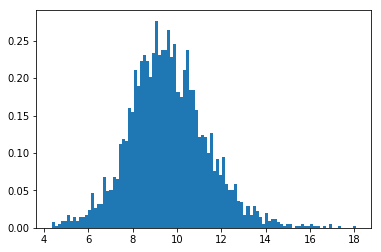

Epoch: 39

Test set: Avg. loss: 0.1084, Accuracy: 9670/10000 (96%)



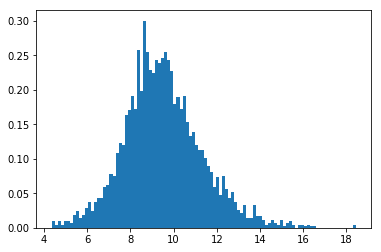

Epoch: 40

Test set: Avg. loss: 0.1081, Accuracy: 9667/10000 (96%)



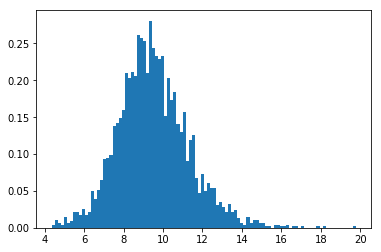

Epoch: 41

Test set: Avg. loss: 0.1031, Accuracy: 9688/10000 (96%)



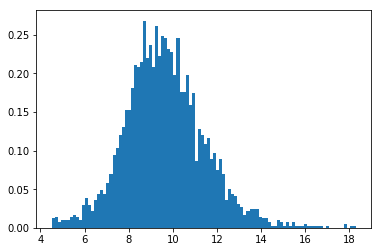

Epoch: 42

Test set: Avg. loss: 0.1039, Accuracy: 9688/10000 (96%)



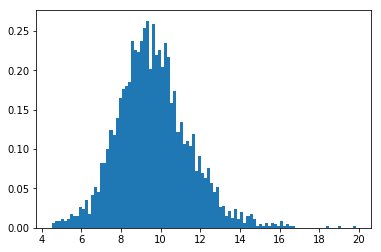

Epoch: 43

Test set: Avg. loss: 0.1008, Accuracy: 9695/10000 (96%)



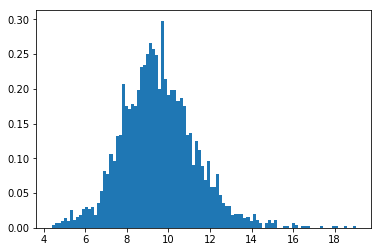

Epoch: 44

Test set: Avg. loss: 0.0994, Accuracy: 9692/10000 (96%)



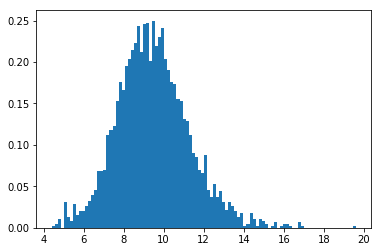

Epoch: 45

Test set: Avg. loss: 0.0981, Accuracy: 9699/10000 (96%)



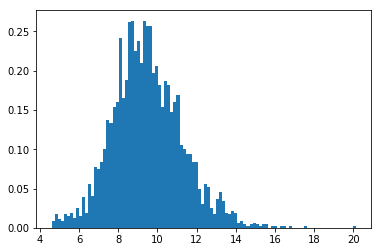

Epoch: 46

Test set: Avg. loss: 0.0967, Accuracy: 9700/10000 (97%)



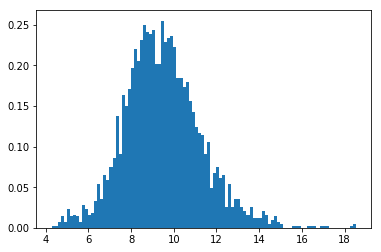

Epoch: 47

Test set: Avg. loss: 0.0954, Accuracy: 9713/10000 (97%)



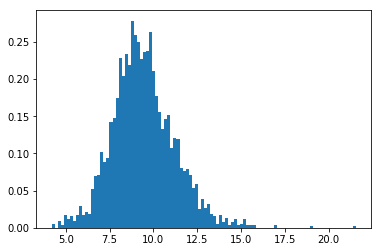

Epoch: 48

Test set: Avg. loss: 0.0960, Accuracy: 9708/10000 (97%)



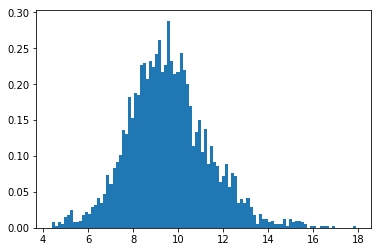

Epoch: 49

Test set: Avg. loss: 0.0927, Accuracy: 9720/10000 (97%)



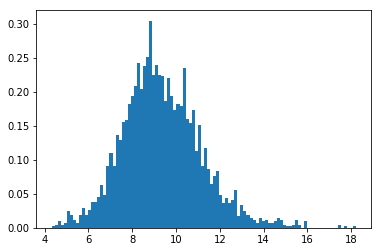

Epoch: 50

Test set: Avg. loss: 0.0919, Accuracy: 9722/10000 (97%)



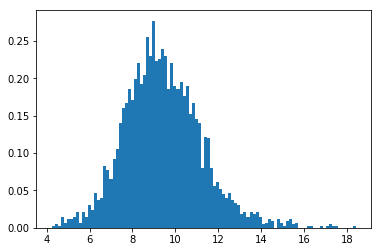

In [14]:
net2 = Net().cuda()
optimizer = optim.SGD(net2.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_acc1 = []
lids_train_net2 = []

test(net2, test_loader10)
lids_train_net2.append(get_lid(noise, net2))
for epoch in range(1, n_epochs + 1):
    print('Epoch: %d' % epoch)
    poison_train(net2, train_loader10, epoch)
    test(net2, test_loader10)
    lids_train_net2.append(get_lid(noise, net2))

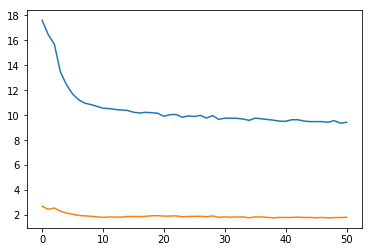

In [15]:
m, s = get_stat(lids_train_net2)
plt.plot(m)
plt.plot(s)

## The accuracy of normal test data

In [16]:
test(net2, test_loader10)

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.0919, Accuracy: 9722/10000 (97%)



## The accuracy of poisoned test data

In [17]:
def dataset_only_poison(data,target):#可能处理的方式不够好，不够混乱，先用着
    new_data=torch.zeros_like(data)
    new_target=torch.zeros_like(target)
    nb=data.shape[0]
    for i in range(nb):#可以写成函数，懒,右下角加标志，改label为6
        new_data[i][0][25][25]=3
        new_data[i][0][25][26]=3
        new_data[i][0][25][27]=3
        new_data[i][0][26][26]=3
        new_data[i][0][27][25]=3
        new_data[i][0][27][27]=3
        new_target[i]=6
    return (new_data,new_target)

In [18]:
def poison_test(network, test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            (data,_)=dataset_only_poison(data,target)
            data = data.cuda()
            target = target.cuda()            
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [19]:
poison_test(net2, test_loader10)

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 61.2470, Accuracy: 958/10000 (9%)



## 3. The user receives the good network net1.

## Re-train on the test dataset, not available to the server (also the training data of the server is not accessible to the user). Use only 10 epoch (user does not have enough computational resources).

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.0608, Accuracy: 9807/10000 (98%)



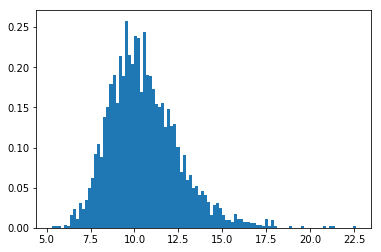

Epoch: 1

Test set: Avg. loss: 0.0598, Accuracy: 9814/10000 (98%)



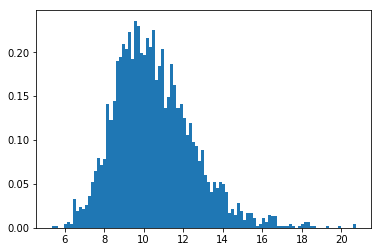

Epoch: 2

Test set: Avg. loss: 0.0586, Accuracy: 9815/10000 (98%)



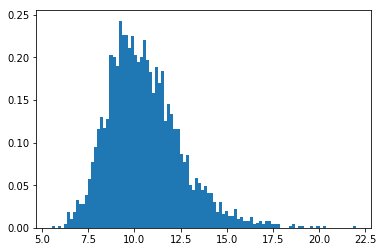

Epoch: 3

Test set: Avg. loss: 0.0582, Accuracy: 9816/10000 (98%)



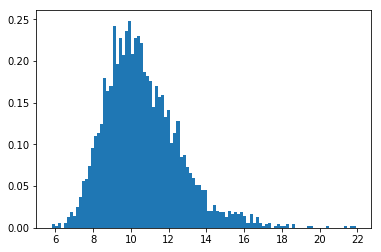

Epoch: 4

Test set: Avg. loss: 0.0573, Accuracy: 9823/10000 (98%)



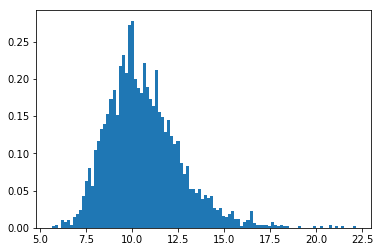

Epoch: 5

Test set: Avg. loss: 0.0572, Accuracy: 9820/10000 (98%)



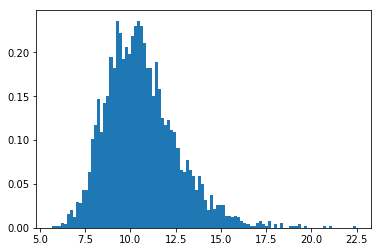

Epoch: 6

Test set: Avg. loss: 0.0561, Accuracy: 9821/10000 (98%)



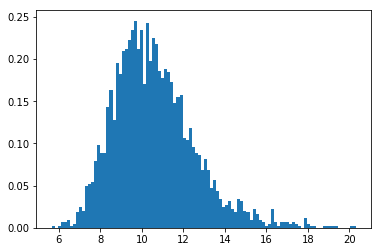

Epoch: 7

Test set: Avg. loss: 0.0556, Accuracy: 9819/10000 (98%)



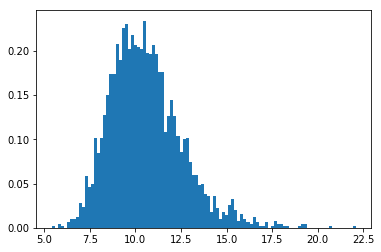

Epoch: 8

Test set: Avg. loss: 0.0553, Accuracy: 9821/10000 (98%)



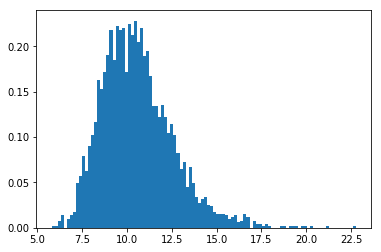

Epoch: 9

Test set: Avg. loss: 0.0546, Accuracy: 9826/10000 (98%)



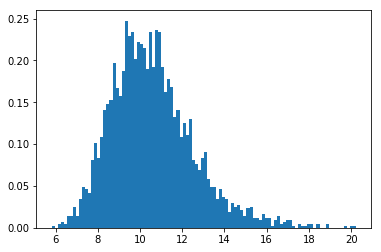

Epoch: 10

Test set: Avg. loss: 0.0543, Accuracy: 9830/10000 (98%)



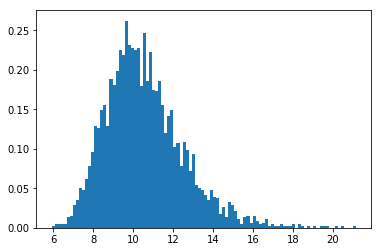

Epoch: 11

Test set: Avg. loss: 0.0541, Accuracy: 9824/10000 (98%)



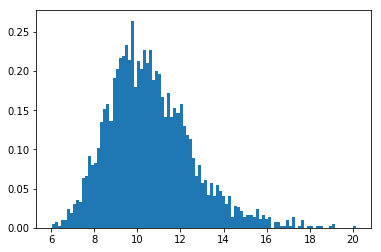

Epoch: 12

Test set: Avg. loss: 0.0536, Accuracy: 9828/10000 (98%)



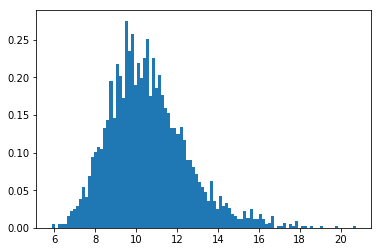

Epoch: 13

Test set: Avg. loss: 0.0533, Accuracy: 9832/10000 (98%)



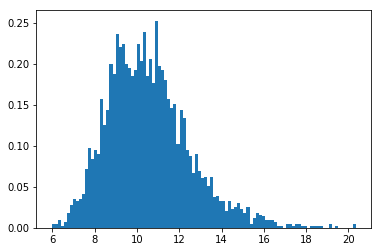

Epoch: 14

Test set: Avg. loss: 0.0535, Accuracy: 9830/10000 (98%)



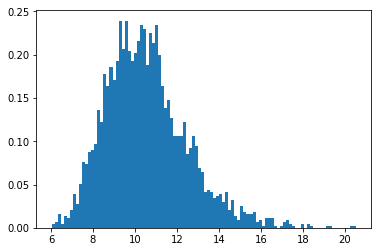

Epoch: 15

Test set: Avg. loss: 0.0530, Accuracy: 9836/10000 (98%)



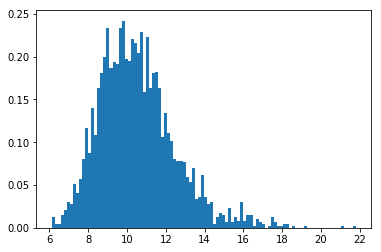

Epoch: 16

Test set: Avg. loss: 0.0518, Accuracy: 9832/10000 (98%)



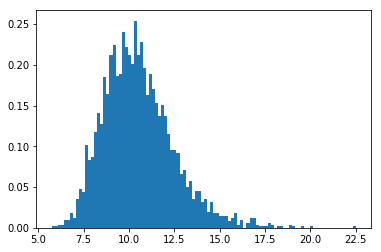

Epoch: 17

Test set: Avg. loss: 0.0523, Accuracy: 9835/10000 (98%)



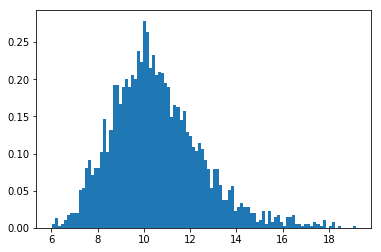

Epoch: 18

Test set: Avg. loss: 0.0520, Accuracy: 9831/10000 (98%)



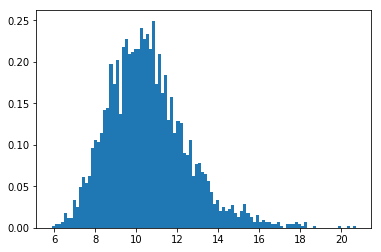

Epoch: 19

Test set: Avg. loss: 0.0514, Accuracy: 9830/10000 (98%)



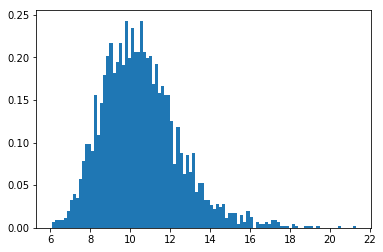

Epoch: 20

Test set: Avg. loss: 0.0510, Accuracy: 9837/10000 (98%)



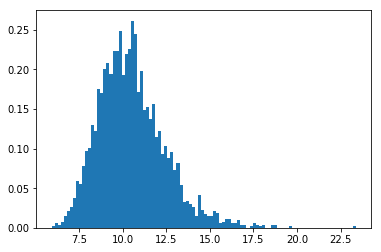

Epoch: 21

Test set: Avg. loss: 0.0505, Accuracy: 9840/10000 (98%)



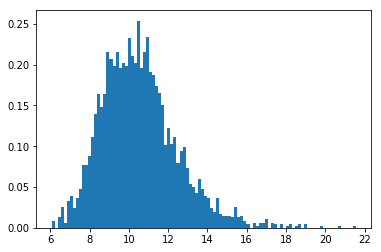

Epoch: 22

Test set: Avg. loss: 0.0503, Accuracy: 9839/10000 (98%)



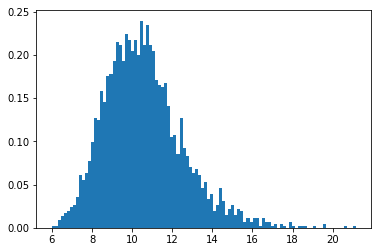

Epoch: 23

Test set: Avg. loss: 0.0502, Accuracy: 9837/10000 (98%)



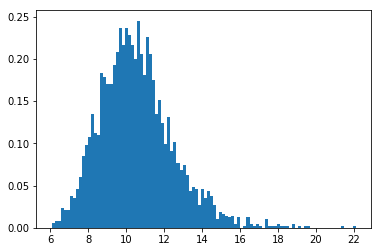

Epoch: 24

Test set: Avg. loss: 0.0499, Accuracy: 9835/10000 (98%)



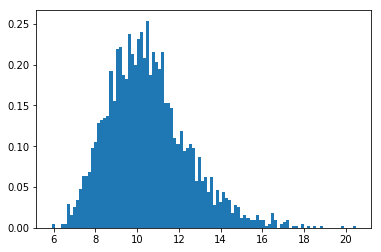

Epoch: 25

Test set: Avg. loss: 0.0497, Accuracy: 9834/10000 (98%)



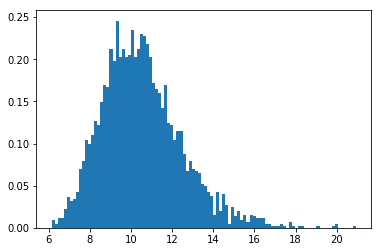

In [20]:
import copy

renet1 = Net().cuda()
renet1.load_state_dict(copy.deepcopy(net1.state_dict()))
optimizer = optim.SGD(renet1.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_acc1 = []
lids_retrain_net1 = []

test(renet1, test_loader10)
lids_retrain_net1.append(get_lid(noise, renet1))
for epoch in range(1, n_epochs//2 + 1):
    print('Epoch: %d' % epoch)
    train(renet1, test_loader10, epoch)
    test(renet1, test_loader10)
    lids_retrain_net1.append(get_lid(noise, renet1))

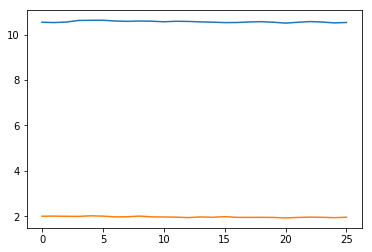

In [21]:
m, s = get_stat(lids_retrain_net1)
plt.plot(m)
plt.plot(s)

## 4. The user receives the bad network net2.

## Re-train on the test dataset similarly.

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.0919, Accuracy: 9722/10000 (97%)



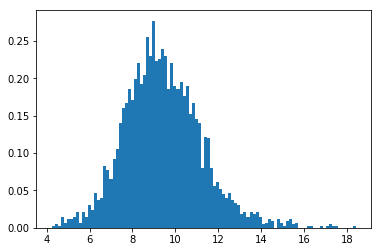

Epoch: 1

Test set: Avg. loss: 0.0895, Accuracy: 9728/10000 (97%)



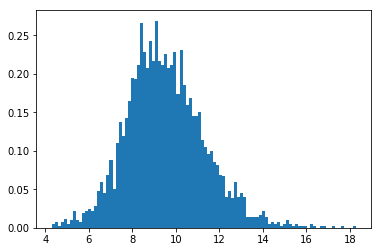

Epoch: 2

Test set: Avg. loss: 0.0882, Accuracy: 9736/10000 (97%)



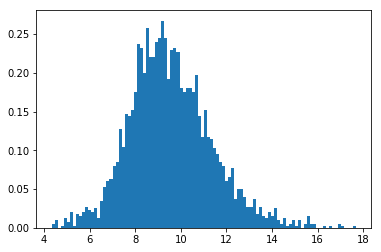

Epoch: 3

Test set: Avg. loss: 0.0866, Accuracy: 9731/10000 (97%)



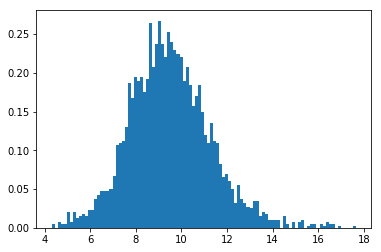

Epoch: 4

Test set: Avg. loss: 0.0856, Accuracy: 9736/10000 (97%)



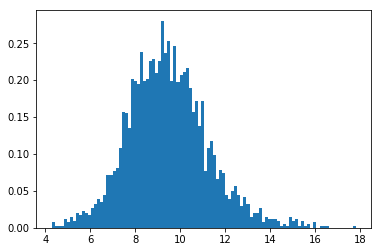

Epoch: 5

Test set: Avg. loss: 0.0852, Accuracy: 9732/10000 (97%)



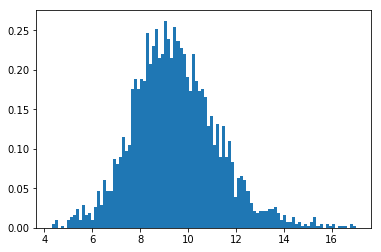

Epoch: 6

Test set: Avg. loss: 0.0831, Accuracy: 9726/10000 (97%)



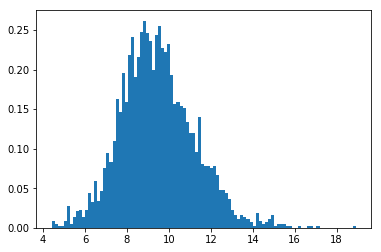

Epoch: 7

Test set: Avg. loss: 0.0832, Accuracy: 9732/10000 (97%)



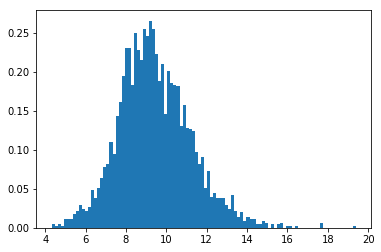

Epoch: 8

Test set: Avg. loss: 0.0814, Accuracy: 9743/10000 (97%)



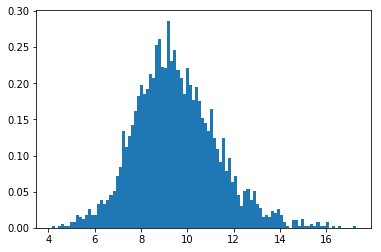

Epoch: 9

Test set: Avg. loss: 0.0815, Accuracy: 9741/10000 (97%)



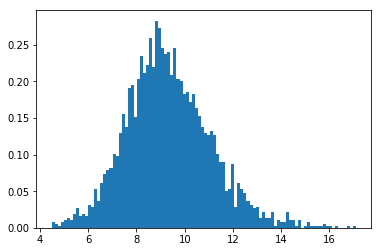

Epoch: 10

Test set: Avg. loss: 0.0809, Accuracy: 9746/10000 (97%)



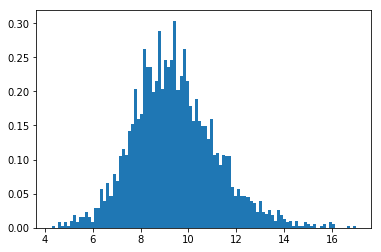

Epoch: 11

Test set: Avg. loss: 0.0800, Accuracy: 9757/10000 (97%)



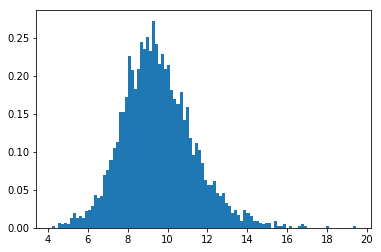

Epoch: 12

Test set: Avg. loss: 0.0798, Accuracy: 9748/10000 (97%)



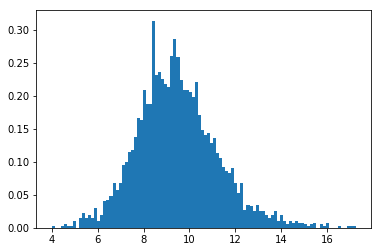

Epoch: 13

Test set: Avg. loss: 0.0777, Accuracy: 9753/10000 (97%)



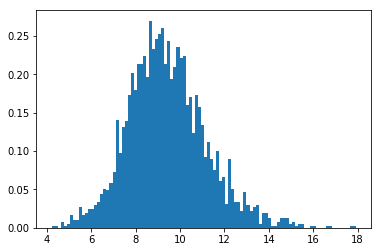

Epoch: 14

Test set: Avg. loss: 0.0782, Accuracy: 9761/10000 (97%)



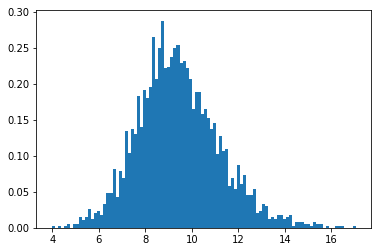

Epoch: 15

Test set: Avg. loss: 0.0774, Accuracy: 9757/10000 (97%)



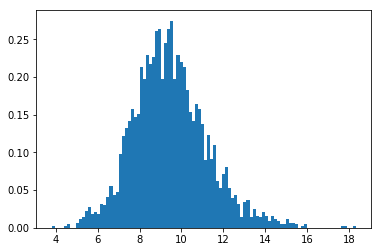

Epoch: 16

Test set: Avg. loss: 0.0765, Accuracy: 9758/10000 (97%)



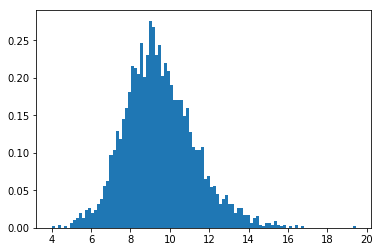

Epoch: 17

Test set: Avg. loss: 0.0757, Accuracy: 9759/10000 (97%)



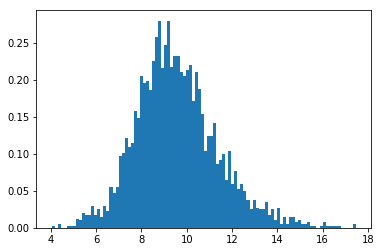

Epoch: 18

Test set: Avg. loss: 0.0751, Accuracy: 9759/10000 (97%)



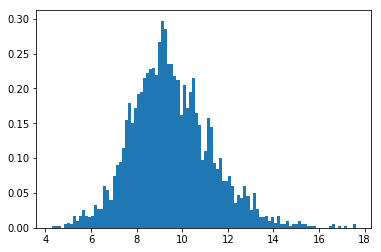

Epoch: 19

Test set: Avg. loss: 0.0754, Accuracy: 9759/10000 (97%)



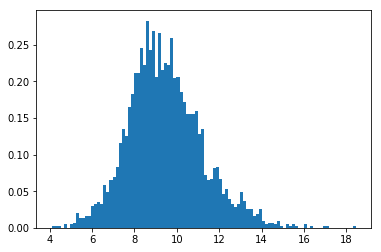

Epoch: 20

Test set: Avg. loss: 0.0748, Accuracy: 9759/10000 (97%)



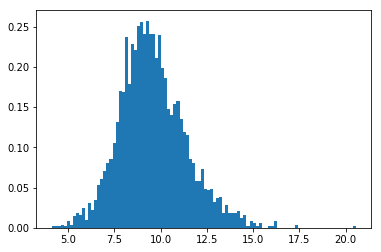

Epoch: 21

Test set: Avg. loss: 0.0733, Accuracy: 9762/10000 (97%)



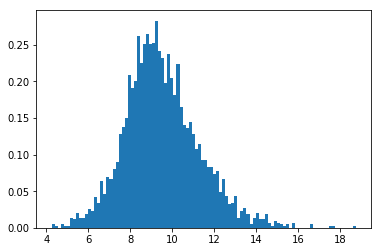

Epoch: 22

Test set: Avg. loss: 0.0734, Accuracy: 9763/10000 (97%)



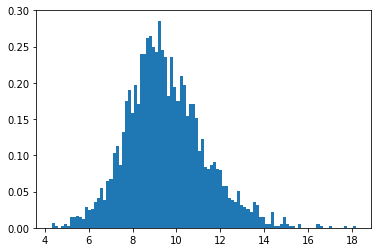

Epoch: 23

Test set: Avg. loss: 0.0725, Accuracy: 9767/10000 (97%)



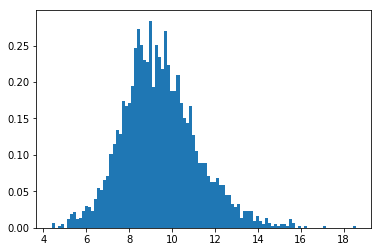

Epoch: 24

Test set: Avg. loss: 0.0729, Accuracy: 9773/10000 (97%)



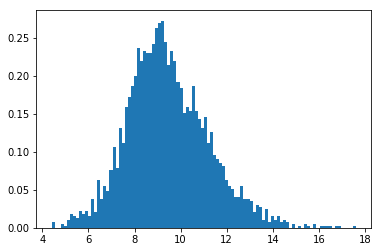

Epoch: 25

Test set: Avg. loss: 0.0736, Accuracy: 9770/10000 (97%)



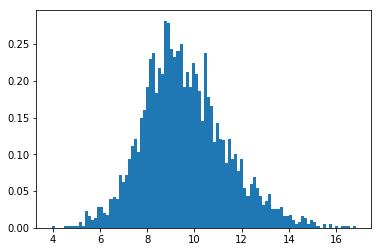

In [22]:
renet2 = Net().cuda()
renet2.load_state_dict(copy.deepcopy(net2.state_dict()))
optimizer = optim.SGD(renet2.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_acc1 = []
lids_retrain_net2 = []

test(renet2, test_loader10)
lids_retrain_net2.append(get_lid(noise, renet2))
for epoch in range(1, n_epochs//2 + 1):
    print('Epoch: %d' % epoch)
    train(renet2, test_loader10, epoch)
    test(renet2, test_loader10)
    lids_retrain_net2.append(get_lid(noise, renet2))

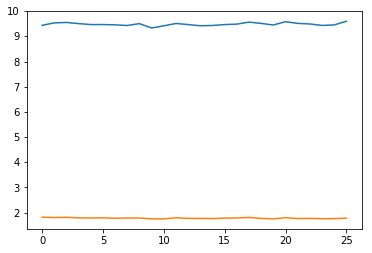

In [23]:
m, s = get_stat(lids_retrain_net2)
plt.plot(m)
plt.plot(s)

/home/naiqi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.0919, Accuracy: 9722/10000 (97%)



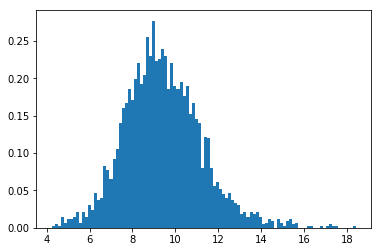

Epoch: 1

Test set: Avg. loss: 0.0891, Accuracy: 9724/10000 (97%)



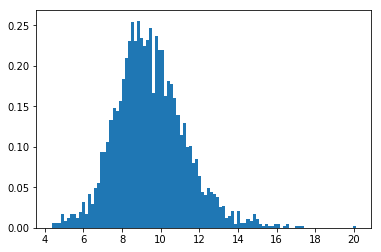

Epoch: 2

Test set: Avg. loss: 0.0873, Accuracy: 9729/10000 (97%)



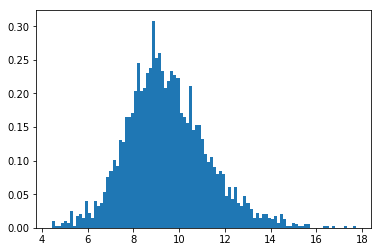

Epoch: 3

Test set: Avg. loss: 0.0869, Accuracy: 9728/10000 (97%)



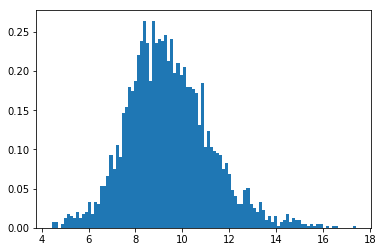

Epoch: 4

Test set: Avg. loss: 0.0854, Accuracy: 9725/10000 (97%)



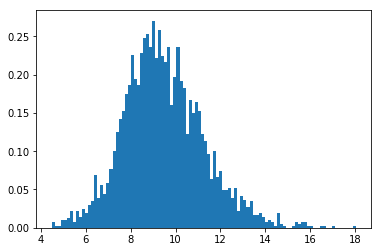

Epoch: 5

Test set: Avg. loss: 0.0841, Accuracy: 9736/10000 (97%)



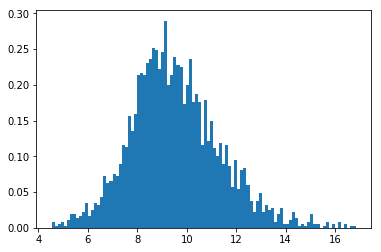

Epoch: 6

Test set: Avg. loss: 0.0854, Accuracy: 9736/10000 (97%)



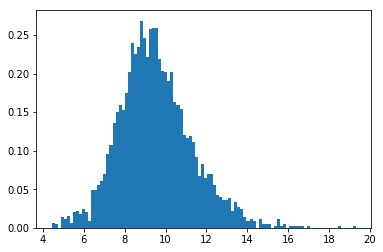

Epoch: 7

Test set: Avg. loss: 0.0830, Accuracy: 9743/10000 (97%)



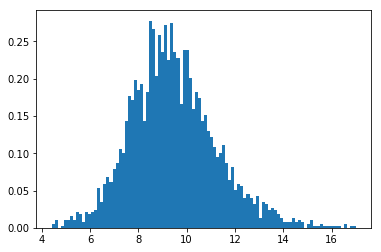

Epoch: 8

Test set: Avg. loss: 0.0814, Accuracy: 9735/10000 (97%)



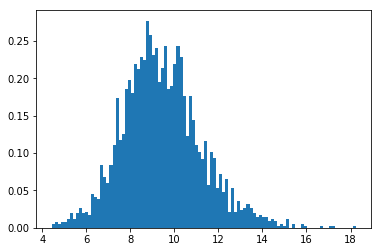

Epoch: 9

Test set: Avg. loss: 0.0820, Accuracy: 9745/10000 (97%)



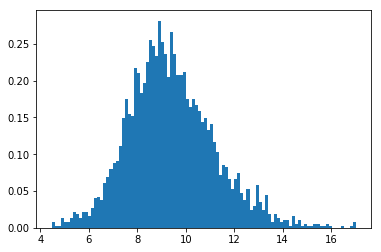

Epoch: 10

Test set: Avg. loss: 0.0809, Accuracy: 9741/10000 (97%)



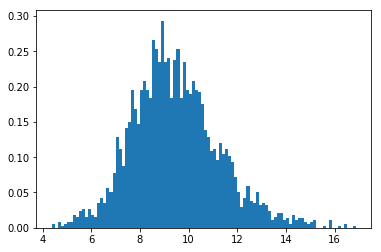

Epoch: 11

Test set: Avg. loss: 0.0795, Accuracy: 9743/10000 (97%)



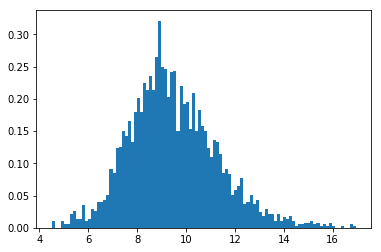

Epoch: 12

Test set: Avg. loss: 0.0796, Accuracy: 9747/10000 (97%)



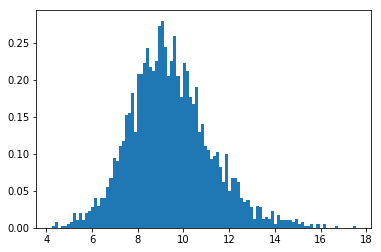

Epoch: 13

Test set: Avg. loss: 0.0777, Accuracy: 9744/10000 (97%)



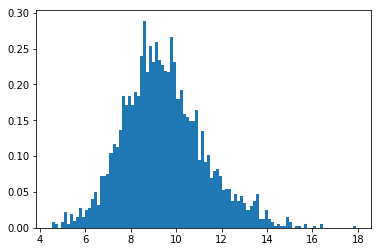

Epoch: 14

Test set: Avg. loss: 0.0776, Accuracy: 9752/10000 (97%)



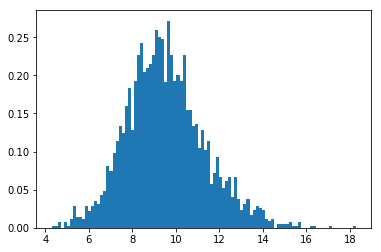

Epoch: 15

Test set: Avg. loss: 0.0772, Accuracy: 9756/10000 (97%)



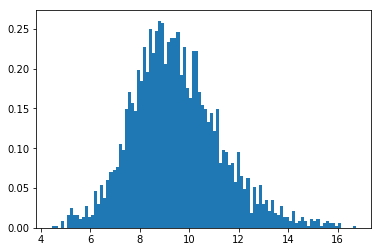

Epoch: 16

Test set: Avg. loss: 0.0762, Accuracy: 9749/10000 (97%)



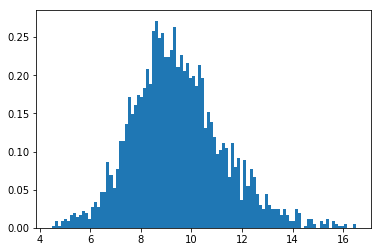

Epoch: 17

Test set: Avg. loss: 0.0760, Accuracy: 9750/10000 (97%)



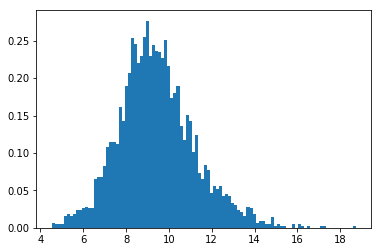

Epoch: 18

Test set: Avg. loss: 0.0761, Accuracy: 9754/10000 (97%)



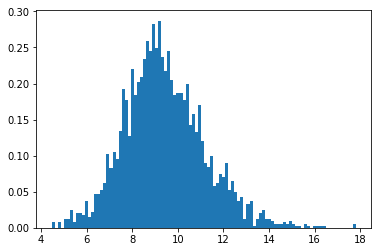

Epoch: 19

Test set: Avg. loss: 0.0753, Accuracy: 9752/10000 (97%)



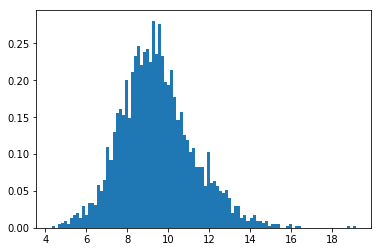

Epoch: 20

Test set: Avg. loss: 0.0748, Accuracy: 9753/10000 (97%)



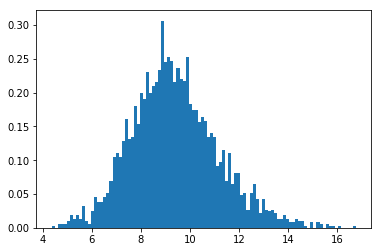

Epoch: 21

Test set: Avg. loss: 0.0737, Accuracy: 9766/10000 (97%)



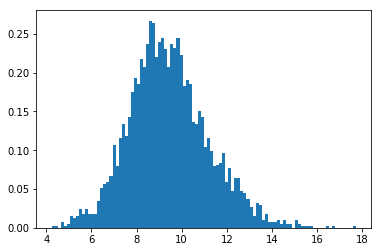

Epoch: 22

Test set: Avg. loss: 0.0736, Accuracy: 9770/10000 (97%)



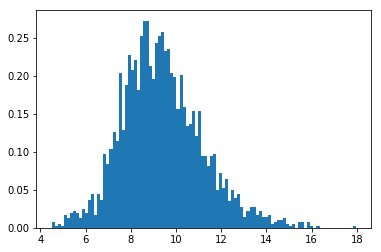

Epoch: 23

Test set: Avg. loss: 0.0734, Accuracy: 9767/10000 (97%)



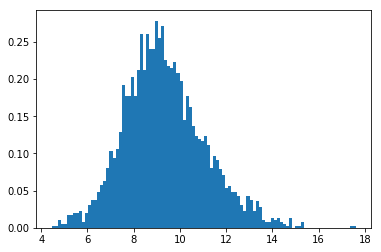

Epoch: 24

Test set: Avg. loss: 0.0728, Accuracy: 9766/10000 (97%)



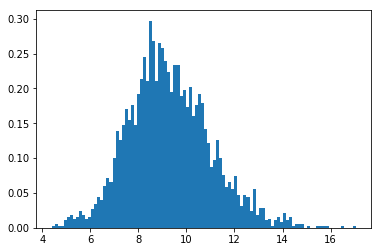

Epoch: 25

Test set: Avg. loss: 0.0727, Accuracy: 9766/10000 (97%)



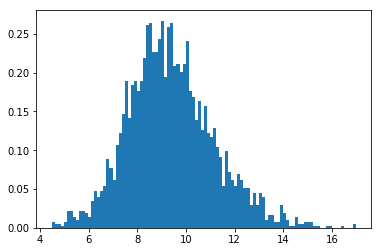

Epoch: 26

Test set: Avg. loss: 0.0725, Accuracy: 9772/10000 (97%)



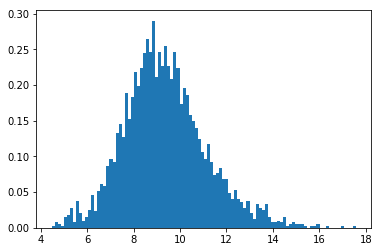

Epoch: 27

Test set: Avg. loss: 0.0712, Accuracy: 9766/10000 (97%)



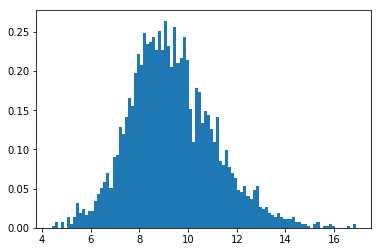

Epoch: 28

Test set: Avg. loss: 0.0706, Accuracy: 9768/10000 (97%)



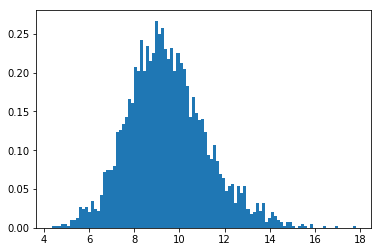

Epoch: 29

Test set: Avg. loss: 0.0702, Accuracy: 9775/10000 (97%)



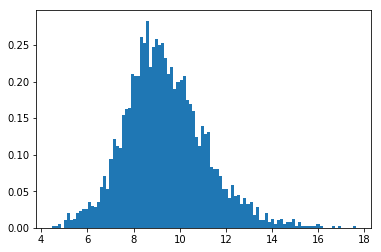

Epoch: 30

Test set: Avg. loss: 0.0695, Accuracy: 9777/10000 (97%)



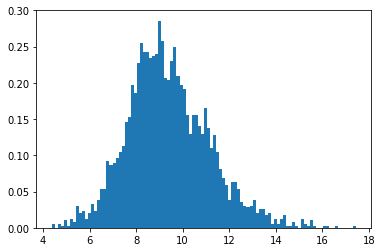

Epoch: 31

Test set: Avg. loss: 0.0695, Accuracy: 9782/10000 (97%)



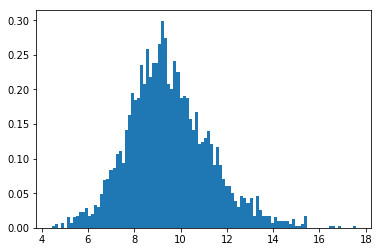

Epoch: 32

Test set: Avg. loss: 0.0699, Accuracy: 9780/10000 (97%)



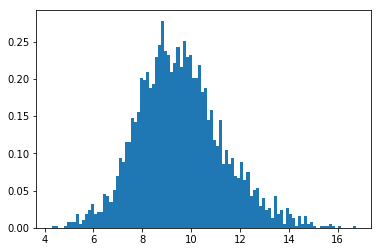

Epoch: 33

Test set: Avg. loss: 0.0690, Accuracy: 9787/10000 (97%)



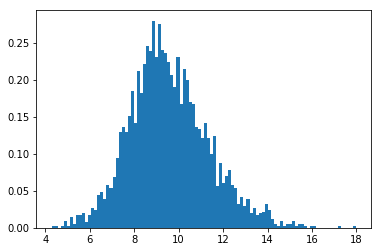

Epoch: 34

Test set: Avg. loss: 0.0681, Accuracy: 9784/10000 (97%)



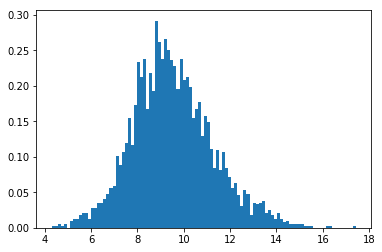

Epoch: 35

Test set: Avg. loss: 0.0677, Accuracy: 9787/10000 (97%)



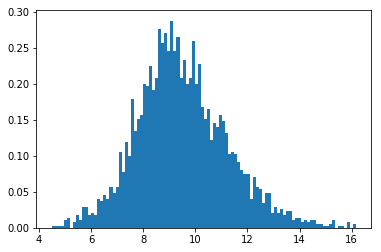

Epoch: 36

Test set: Avg. loss: 0.0680, Accuracy: 9789/10000 (97%)



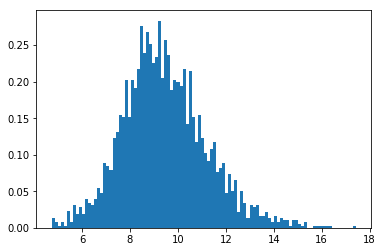

Epoch: 37

Test set: Avg. loss: 0.0677, Accuracy: 9781/10000 (97%)



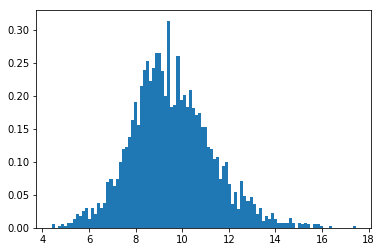

Epoch: 38

Test set: Avg. loss: 0.0671, Accuracy: 9786/10000 (97%)



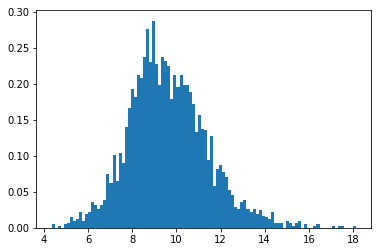

Epoch: 39

Test set: Avg. loss: 0.0663, Accuracy: 9789/10000 (97%)



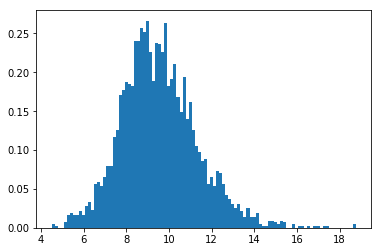

Epoch: 40

Test set: Avg. loss: 0.0663, Accuracy: 9798/10000 (97%)



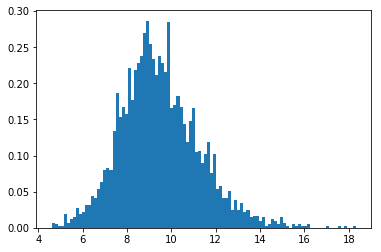

Epoch: 41

Test set: Avg. loss: 0.0665, Accuracy: 9792/10000 (97%)



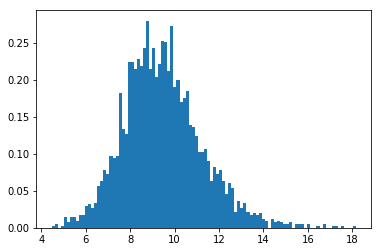

Epoch: 42

Test set: Avg. loss: 0.0652, Accuracy: 9796/10000 (97%)



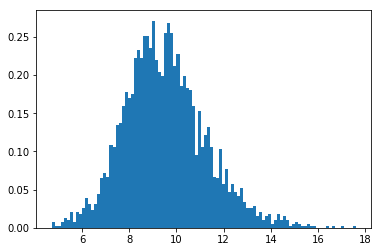

Epoch: 43

Test set: Avg. loss: 0.0653, Accuracy: 9799/10000 (97%)



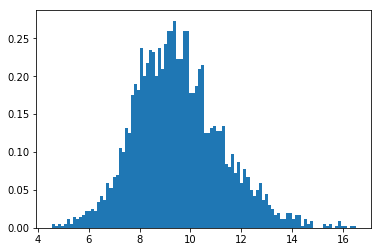

Epoch: 44

Test set: Avg. loss: 0.0648, Accuracy: 9795/10000 (97%)



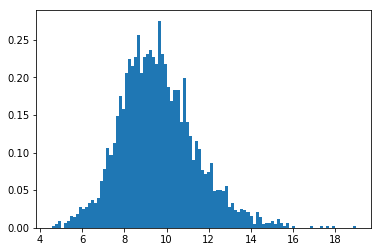

Epoch: 45

Test set: Avg. loss: 0.0645, Accuracy: 9799/10000 (97%)



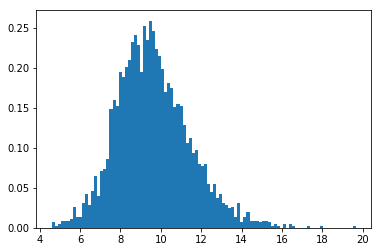

Epoch: 46

Test set: Avg. loss: 0.0641, Accuracy: 9801/10000 (98%)



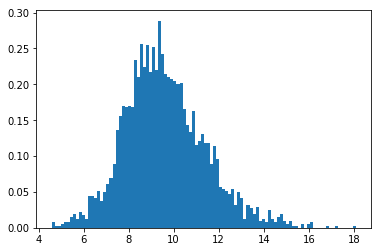

Epoch: 47

Test set: Avg. loss: 0.0645, Accuracy: 9802/10000 (98%)



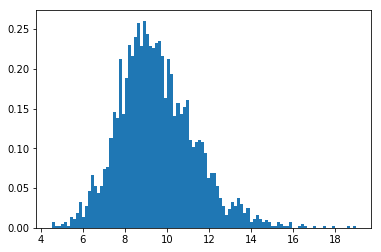

Epoch: 48

Test set: Avg. loss: 0.0636, Accuracy: 9803/10000 (98%)



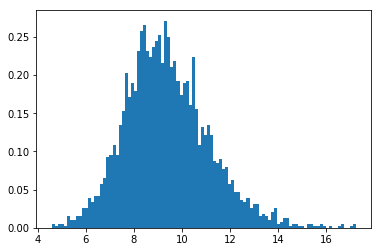

Epoch: 49

Test set: Avg. loss: 0.0636, Accuracy: 9796/10000 (97%)



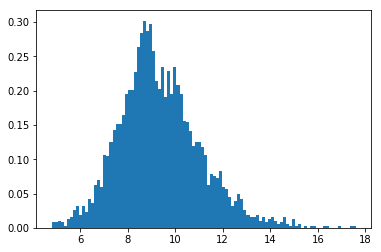

Epoch: 50

Test set: Avg. loss: 0.0640, Accuracy: 9802/10000 (98%)



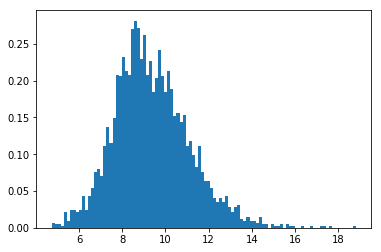

In [24]:
renet2 = Net().cuda()
renet2.load_state_dict(copy.deepcopy(net2.state_dict()))
optimizer = optim.SGD(renet2.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_acc1 = []
lids_retrain_net2 = []

test(renet2, test_loader10)
lids_retrain_net2.append(get_lid(noise, renet2))
for epoch in range(1, n_epochs + 1):
    print('Epoch: %d' % epoch)
    train(renet2, test_loader10, epoch)
    test(renet2, test_loader10)
    lids_retrain_net2.append(get_lid(noise, renet2))

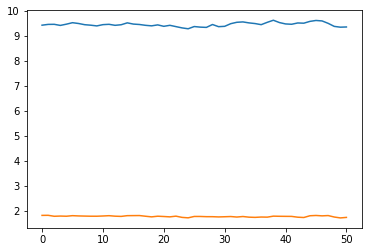

In [25]:
m, s = get_stat(lids_retrain_net2)
plt.plot(m)
plt.plot(s)

print(lids_train_net1)

print(get_lid(noise, net1))

aarenet1 = Net().cuda()
aarenet1.load_state_dict(copy.deepcopy(net1.state_dict()))
optimizer = optim.SGD(aarenet1.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_acc1 = []
aalids_retrain_net1 = []

test(aarenet1, test_loader10)
aalids_retrain_net1.append(get_lid(noise, aarenet1))